In [ ]:
#import google drive for the dataset file 
from google.colab import drive 
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#import the libraries 
import numpy as np
import pandas as pd

In [ ]:
#import the dataset file from the drive 
df = pd.read_csv("/gdrive/My Drive/DataSet.csv")

In [ ]:
df

,Unnamed: 0,REVIEW,SENTIMENT
0,0,Friendly patient (pun not intended) attitude o...,Positive
1,1,I had tried to register at this surgery as my ...,Positive
2,2,"Clean, smart surgery, polite and friendly rece...",Positive
3,3,It's been a year since I have been with this ...,Positive
4,4,I have lived in many parts of the Country and ...,Positive
...,...,...,...
26024,10672,My friend who was in for at least a month with...,Negative
26025,10673,Id be interested in your views and help in und...,Negative
26026,10674,"More nice staff like those two, the nurses wer...",Negative
26027,10675,Visited my relative on WD14 today and the nurs...,Negative


In [ ]:
#Remove the extra column
df = df[["REVIEW","SENTIMENT"]]
df

,REVIEW,SENTIMENT
0,Friendly patient (pun not intended) attitude o...,Positive
1,I had tried to register at this surgery as my ...,Positive
2,"Clean, smart surgery, polite and friendly rece...",Positive
3,It's been a year since I have been with this ...,Positive
4,I have lived in many parts of the Country and ...,Positive
...,...,...
26024,My friend who was in for at least a month with...,Negative
26025,Id be interested in your views and help in und...,Negative
26026,"More nice staff like those two, the nurses wer...",Negative
26027,Visited my relative on WD14 today and the nurs...,Negative


In [ ]:
#Shuffle the data for increasing the accuracy of the model
df = df.sample(frac = 1).reset_index(drop=True)

In [ ]:
#plot the dataset
import seaborn as sns

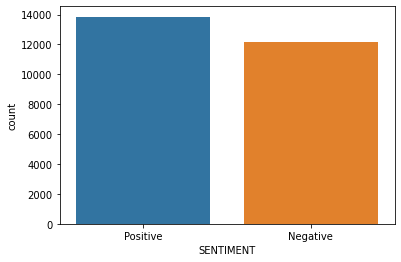

In [ ]:
sns.countplot(x = 'SENTIMENT', data = df)

In [ ]:
#import libraries for data cleaning 
import spacy 
nlp = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS
import string

In [ ]:
stopwords = list(STOP_WORDS)
punct = string.punctuation

In [ ]:
#Create function for data cleaning, remove stop words and punctuation
def data_cleaning(sentence):
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
        
    clean_tokens = []
    for token in tokens:
        if token not in stopwords and token not in punct:
            clean_tokens.append(token)
    return clean_tokens
# Function to convert to string
def listToString(s): 
    str1 = " "     
    return (str1.join(s))

In [ ]:
#Create a cleaned dataset and store it in a form of list 
x = []
reviews = list(df['REVIEW'])
for review in reviews:
    x.append(listToString(data_cleaning(review)))

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
xt = []
#each sentence will be stored as an array inside the xt list 
for sentence in x:
  xt.append(np.array(word_tokenize(sentence)))

In [ ]:
#Convert the list into numpy array 
xt = np.array(xt)

In [ ]:
t = list(set(np.concatenate(xt)))

In [ ]:
t = np.array([i for i in t if i.isalpha()])

In [ ]:
t = dict(enumerate(t))

In [ ]:
len(t)

22265

In [ ]:
#Assigne the serial numbers as keys for the words 
word_to_index = {b:a for a, b in t.items()}

In [ ]:
#Add each word to the list for its coreesponding value(index)
b = []
for i in x:
  c = []
  for j in i:
    try:
      c.append(word_to_index[j])
    except:
      pass
  b.append(c)


In [ ]:
len(b)

26029

In [ ]:
df["SENTIMENT"][0]

'Positive'

In [ ]:
#Create one hot vector for positive and negative reviews 
sentiment = []
for i in range(len(df)):
  if df["SENTIMENT"][i] == "Positive":
    sentiment.append([1,0])
  else:
    sentiment.append([0,1])

In [ ]:
#Test train split
from sklearn.model_selection import train_test_split
#Random state can be any integer. It ensures that dataset passed in the train and test models be same. It ensures that prediction remain same 
X_train, X_test, Y_train, Y_test = train_test_split(b, sentiment, test_size = 0.20, random_state = 0)

In [ ]:
#Convert the train and test datas into numpy array 
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [ ]:
#Create multi hot vector 
def multi_hot_encode(sequences, dimension):
  result = np.zeros((len(sequences), dimension))
  for i in range(len(sequences)):
    for j in range(len(sequences[i])):
      result[i][sequences[i][j]] = 1
  return result

In [ ]:
X_train = multi_hot_encode(X_train, 22310)
X_test = multi_hot_encode(X_test, 22310)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(20823, 22310)
(20823, 2)
(5206, 22310)
(5206, 2)


In [ ]:
#import nlp libraries 
from tensorflow.keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.layers.core import Activation, Dense


In [ ]:
#create a model for training 
def create_model():
    model = Sequential()
    model.add(Embedding(20823, 32, input_length = 22310))
    model.add(Flatten())
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(2, activation='sigmoid')) #binary classification
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model
  
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 22310, 32)         666336    
_________________________________________________________________
flatten (Flatten)            (None, 713920)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                22845472  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 23,511,874
Trainable params: 23,511,874
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#Train the model 
import matplotlib.pyplot as plt
def fit(model):
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=128, verbose=1)
    scores =  model.evaluate(X_test, Y_test, verbose=0)
    history_dict = history.history
    return scores,history_dict
    
scores,history_dict = fit(model)

Epoch 1/20
163/163 [==============================] - 182s 1s/step - loss: 0.6929 - accuracy: 0.5247 - val_loss: 0.6918 - val_accuracy: 0.5259
Epoch 2/20
163/163 [==============================] - 181s 1s/step - loss: 0.6913 - accuracy: 0.5289 - val_loss: 0.6936 - val_accuracy: 0.5259
Epoch 3/20
163/163 [==============================] - 181s 1s/step - loss: 0.6903 - accuracy: 0.5358 - val_loss: 0.6914 - val_accuracy: 0.5259
Epoch 4/20
163/163 [==============================] - 182s 1s/step - loss: 0.6898 - accuracy: 0.5349 - val_loss: 0.6900 - val_accuracy: 0.5259
Epoch 5/20
163/163 [==============================] - 182s 1s/step - loss: 0.6890 - accuracy: 0.5367 - val_loss: 0.6933 - val_accuracy: 0.5259
Epoch 6/20
163/163 [==============================] - 182s 1s/step - loss: 0.6884 - accuracy: 0.5436 - val_loss: 0.6911 - val_accuracy: 0.5259
Epoch 7/20
163/163 [==============================] - 182s 1s/step - loss: 0.6875 - accuracy: 0.5436 - val_loss: 0.6876 - val_accuracy: 0.5540

In [ ]:
#Testing the trained model 

In [ ]:
a = ['The hospital was very good. I am satisfied with my treatment']

In [ ]:
print(len(a))

1


In [ ]:
b = []
for i in a:
  c = []
  for j in i.split():
    try:
      c.append(word_to_index[j])
    except:
      pass
  b.append(c)

In [ ]:
b = np.array(b)

In [ ]:
b

array([[17265, 16021,   184,  7079, 12532, 10255,  7955]])

In [ ]:
validation = multi_hot_encode(b,22310)

In [ ]:
validation

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
print('Neagtive, positive')
print(model.predict(validation))

Neagtive, positive
[[0.3289116 0.6795203]]
